In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import pandas as pd
from tqdm.auto import tqdm, trange


In [11]:
class LinearRegressionFFN(nn.Module):
    def __init__(self, input_dim, hidden_dim=50):
        super(LinearRegressionFFN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)

    def forward(self, input):
        hidden_output = F.softmax(self.linear1(input), dim=-1)
        return torch.sigmoid(self.linear2(hidden_output))


In [12]:
train_file = "../model_data/branch_train.csv"
val_file = "../model_data/branch_val.csv"

branch_train_data = pd.read_csv(train_file)
branch_val_data = pd.read_csv(val_file)

branch_training_data = [branch_train_data, branch_val_data]

branch_training_data = pd.concat(branch_training_data)

In [13]:
branch_prob = 'branch_prob'
raw_string = 'raw_string'

clean_train_data = branch_training_data.loc[:, ~branch_training_data.columns.isin([branch_prob, raw_string])]
clean_train_labels = branch_training_data[branch_prob].tolist()

training_data = [(torch.Tensor(clean_train_data.iloc[i].tolist()), torch.Tensor([clean_train_labels[i]])) for i in range(len(clean_train_data))]

## Training Loop

In [14]:
model = LinearRegressionFFN(input_dim=len(clean_train_data.columns))
model.train()

epochs = 40
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=.001)

rmses = []
for epoch in range(epochs):
    for step, data in enumerate(tqdm(training_data)):
        inputs, label = data

        optimizer.zero_grad()
        prediction = model(inputs)
        loss = criterion(prediction, label)

        if step == 0:
            rmses.append(float(loss))

        loss.backward()
        optimizer.step()

100%|██████████| 1623/1623 [00:00<00:00, 2278.36it/s]


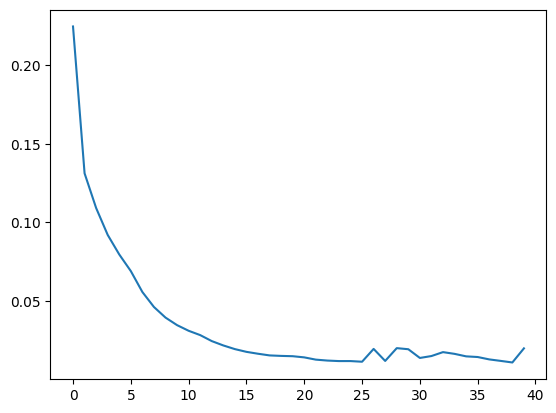

In [15]:
import matplotlib.pyplot as plt

plt.plot(rmses)

In [16]:
test_file = "../model_data/branch_test.csv"
branch_test_data = pd.read_csv(test_file)

branch_prob = 'branch_prob'
raw_string = 'raw_string'

clean_test_data = branch_test_data.loc[:, ~branch_test_data.columns.isin([branch_prob, raw_string])]
clean_test_labels = branch_test_data[branch_prob].tolist()

test_data = [(torch.Tensor(clean_test_data.iloc[i].tolist()), torch.Tensor([clean_test_labels[i]])) for i in range(len(clean_test_data))]

In [17]:
model.eval()

predictions = []

with torch.no_grad():
    for step, data in enumerate(tqdm(test_data)):
        inputs, label = data
        prediction = model(inputs)
        predictions.extend(prediction)

100%|██████████| 279/279 [00:00<00:00, 18721.28it/s]


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(f"RMSE for Test Set: {mean_squared_error(clean_test_labels, predictions, squared=False)}") #RMSE
print(f"MAE for Test Set: {mean_absolute_error(clean_test_labels, predictions)}")

RMSE for Test Set: 0.38806847954991686
MAE for Test Set: 0.3292333661598665


In [19]:
predictions_file = "pytorch_test_predictions.csv"

test_predictions = [predictions[i].item() for i in range(len(predictions))]

test_predictions = pd.Series(test_predictions)

test_predictions.to_csv(predictions_file, index=False, header=False)

In [20]:
pytorch_file = "pytorch_branch_model.pt"

torch.save(model.state_dict(), pytorch_file)